In [1]:
# Install required packages
import subprocess
import sys

def install_packages():
    packages = ['pandas', 'sqlparse', 'pymysql', 'matplotlib', 'seaborn', 'numpy']
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_packages()

# Suppress pandas warnings for DB-API connections
import warnings
warnings.filterwarnings('ignore', message='.*pandas only supports SQLAlchemy connectable.*')

print(" Packages installed and warnings suppressed!")

 Packages installed and warnings suppressed!


In [2]:
# Import the optimizer and required libraries
import os
import time
import json
import hashlib
import statistics
import re

sys.path.append('..')  # Add parent directory to path

try:
    from mariadb_autoopt import optimize_once
    from mariadb_autoopt.magic import optimize_and_show
    print("MariaDB Auto-Optimizer imported successfully!")
except ImportError as e:
    print(f"Could not import mariadb_autoopt: {e}")
    print(" Make sure the package is installed and path is correct")

import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("✅ Libraries imported successfully!")

MariaDB Auto-Optimizer imported successfully!
✅ Libraries imported successfully!


In [3]:
# ---------------------------------------------
# 🔹 SMART AUTO-OPTIMIZER DECISION ENGINE
# ---------------------------------------------

# Global query history for learning
query_history = {}

def get_query_hash(query):
    """Create a hash of the query for tracking performance history"""
    return hashlib.md5(query.strip().encode()).hexdigest()[:10]

def detect_table_size(conn, table_name="routes"):
    """Detect total row count and classify table size with dynamic thresholds"""
    try:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            rows = cursor.fetchone()[0]

        # Dynamic thresholds based on typical performance characteristics
        if rows < 50_000:
            return "small", rows
        elif rows < 500_000:
            return "medium", rows
        else:
            return "large", rows
    except Exception as e:
        print(f"Could not detect table size: {e}")
        return "unknown", 0

def detect_query_type(query):
    """Infer query type from SQL keywords"""
    q = query.lower()
    if "join" in q:
        return "join"
    elif "group by" in q:
        return "aggregation"
    elif "where" in q:
        return "filter"
    else:
        return "simple"

def get_query_cost(conn, query):
    """Get query cost from MariaDB's optimizer estimates"""
    try:
        with conn.cursor() as cursor:
            # Try to get cost from EXPLAIN FORMAT=JSON
            cursor.execute(f"EXPLAIN FORMAT=JSON {query}")
            result = cursor.fetchone()
            if result and result[0]:
                explain_data = json.loads(result[0])
                cost = explain_data.get('query_block', {}).get('cost_info', {}).get('query_cost', None)
                if cost:
                    return float(cost)
    except Exception as e:
        print(f"Could not get query cost: {e}")

    # Fallback: estimate cost based on table size and query complexity
    size_label, rows = detect_table_size(conn)
    base_cost = rows / 1000  # Simple heuristic

    # Adjust based on query complexity
    if "join" in query.lower():
        base_cost *= 2
    if "group by" in query.lower():
        base_cost *= 1.5
    if "order by" in query.lower():
        base_cost *= 1.2

    return base_cost

def enhanced_optimization_strategy(conn, query):
    """Enhanced strategy that focuses on actual performance bottlenecks"""
    size_label, rows = detect_table_size(conn)
    query_type = detect_query_type(query)
    cost = get_query_cost(conn, query)

    print(f"\nTable Size: {rows:,} rows ({size_label})")
    print(f"Query Type: {query_type}")
    print(f"Estimated Query Cost: {cost:.1f}")

    # More conservative strategy
    if size_label == "small" or cost < 50:
        print("Mode: Analysis Only (query already efficient)")
        return "analyze_only"
    elif query_type == "join" and rows > 10000:
        print("Mode: Join Optimization (focus on foreign keys)")
        return "join_optimize"
    elif query_type == "aggregation" and "GROUP BY" in query.upper():
        print("Mode: Aggregation Optimization (group by indexes)")
        return "aggregation_optimize"
    elif cost > 1000:
        print("Mode: Critical Optimization (high-cost query)")
        return "critical_optimize"
    else:
        print("⚡ Mode: Selective Optimization (targeted indexes)")
        return "selective_optimize"

def get_actual_columns_from_query(conn, query):
    """Enhanced column extraction with table alias resolution"""
    actual_columns = []
    query_lower = query.lower()

    # First, map table aliases to real table names
    table_aliases = {}

    # Pattern to find table aliases: "FROM table alias" or "JOIN table alias"
    alias_patterns = [
        r'from\s+(\w+)\s+(\w+)',
        r'join\s+(\w+)\s+(\w+)',
        r'from\s+(\w+)\s+as\s+(\w+)',
        r'join\s+(\w+)\s+as\s+(\w+)'
    ]

    for pattern in alias_patterns:
        matches = re.finditer(pattern, query_lower)
        for match in matches:
            table_name, alias = match.groups()
            table_aliases[alias] = table_name
            print(f"   Found alias: {alias} → {table_name}")

    # Now extract columns with proper table resolution
    column_patterns = [
        r'where\s+(\w+)\.(\w+)\s*[=<>!]',
        r'join\s+\w+\s+on\s+(\w+)\.(\w+)\s*=\s*\w+\.\w+',
        r'group by\s+(\w+)\.(\w+)',
        r'order by\s+(\w+)\.(\w+)',
        r'having\s+\w+\s+[=<>!]\s*\w+\.(\w+)',
        r'select.*?(\w+)\.(\w+)\s+as',
        r'on\s+(\w+)\.(\w+)\s*=\s*\w+\.\w+'
    ]

    for pattern in column_patterns:
        matches = re.finditer(pattern, query_lower)
        for match in matches:
            table_ref, column = match.groups()

            # Resolve alias to real table name
            actual_table = table_aliases.get(table_ref, table_ref)

            # Only include if it's a real table (not a subquery alias)
            real_tables = ['routes', 'airports', 'airlines', 'r', 'a', 'al', 'src', 'dest']
            if actual_table in real_tables:
                # Map common aliases to real tables
                if actual_table == 'r': actual_table = 'routes'
                elif actual_table == 'a': actual_table = 'airports'
                elif actual_table == 'al': actual_table = 'airlines'
                elif actual_table == 'src': actual_table = 'airports'
                elif actual_table == 'dest': actual_table = 'airports'

                actual_columns.append((actual_table, column))
                print(f"   Column found: {actual_table}.{column}")

    # Remove duplicates and return
    return list(set(actual_columns))

def create_smart_indexes(conn, query):
    """Create indexes based on actual query patterns with table validation"""
    actual_columns = get_actual_columns_from_query(conn, query)
    created_indexes = []

    print(f"Found {len(actual_columns)} relevant columns in query")

    if not actual_columns:
        print("   ℹNo indexable columns found in query")
        return created_indexes

    # Group columns by table
    columns_by_table = {}
    for table, column in actual_columns:
        if table not in columns_by_table:
            columns_by_table[table] = []
        if column not in columns_by_table[table]:
            columns_by_table[table].append(column)

    # Validate tables exist and get their actual columns
    valid_tables = {}
    with conn.cursor() as cursor:
        for table in columns_by_table.keys():
            try:
                cursor.execute(f"SHOW COLUMNS FROM {table}")
                valid_columns = [row[0] for row in cursor.fetchall()]
                valid_tables[table] = valid_columns
                print(f"   Table {table} has {len(valid_columns)} columns")
            except Exception as e:
                print(f"   Table {table} doesn't exist: {e}")

    # Create strategic indexes only for valid tables/columns
    for table, columns in columns_by_table.items():
        if table not in valid_tables:
            print(f"   Skipping {table} - table not found")
            continue

        valid_columns = [col for col in columns if col in valid_tables[table]]

        if not valid_columns:
            print(f"   No valid columns found for table {table}")
            continue

        print(f"   Creating indexes for {table}: {valid_columns}")

        # Create composite index for multiple columns
        if len(valid_columns) >= 2:
            idx_name = f"idx_{table}_composite_{'_'.join(valid_columns[:2])}"
            composite_cols = ', '.join(valid_columns[:2])
            sql = f"CREATE INDEX {idx_name} ON {table} ({composite_cols})"

            try:
                with conn.cursor() as cursor:
                    cursor.execute(sql)
                created_indexes.append(idx_name)
                print(f"   Created composite index: {idx_name}")
            except Exception as e:
                print(f"   Failed to create index {idx_name}: {e}")

        # Also create single-column indexes for important columns
        for column in valid_columns:
            if column in ['country', 'city', 'stops', 'active', 'source_airport_id', 'dest_airport_id', 'airline_id']:
                idx_name = f"idx_{table}_{column}"
                sql = f"CREATE INDEX {idx_name} ON {table} ({column})"

                try:
                    with conn.cursor() as cursor:
                        cursor.execute(sql)
                    created_indexes.append(idx_name)
                    print(f"   Created single-column index: {idx_name}")
                except Exception as e:
                    print(f"   Failed to create index {idx_name}: {e}")

    return created_indexes

def validate_query_improvement(conn, query, before_time, after_time, threshold=0.10):
    """Validate if optimization actually helped (10% improvement threshold)"""
    if after_time >= before_time:
        return False  # No improvement or got worse

    improvement = (before_time - after_time) / before_time
    return improvement >= threshold  # At least 10% improvement

def cleanup_indexes(conn, index_list):
    """Clean up specific indexes"""
    if not index_list:
        return

    print(f"\n🧹 Cleaning up {len(index_list)} indexes...")
    for index_spec in index_list:
        try:
            # Extract table and index name
            if "idx_" in index_spec:
                parts = index_spec.split('_')
                table = parts[1] if len(parts) > 1 else None
                if table:
                    with conn.cursor() as cursor:
                        cursor.execute(f"ALTER TABLE {table} DROP INDEX IF EXISTS `{index_spec}`")
                    print(f"   Cleaned up: {index_spec}")
        except Exception as e:
            print(f"   Failed to clean up {index_spec}: {e}")

    conn.commit()

def filter_bad_suggestions(suggestions, query):
    """Aggressively filter out bad index suggestions"""
    good_suggestions = []
    bad_patterns = [
        'num_routes', 'total_routes', 'route_count', 'avg_stops',
        'total_departures', 'unique_destinations', 'avg_connecting_stops'
    ]

    for suggestion in suggestions:
        # Skip suggestions with computed columns
        if any(pattern in suggestion.lower() for pattern in bad_patterns):
            continue

        # Skip suggestions with single-letter table names (likely aliases)
        if re.search(r'ON\s+[a-z]\s*\(', suggestion.lower()):
            continue

        good_suggestions.append(suggestion)

    print(f"🚫 Filtered {len(suggestions) - len(good_suggestions)} bad suggestions")
    return good_suggestions

def record_query_performance(query_hash, before_time, after_time, strategy):
    """Record query performance for learning"""
    if before_time > 0 and after_time is not None:
        # FIXED: Correct improvement calculation
        if after_time < before_time:  # Actually faster
            improvement = ((before_time - after_time) / before_time) * 100
        else:  # Got slower
            improvement = -((after_time - before_time) / before_time) * 100
        query_history[query_hash] = {
            'improvement': improvement,
            'strategy': strategy,
            'before_time': before_time,
            'after_time': after_time,
            'timestamp': time.time()
        }

def reuse_learnings(query, current_strategy):
    """Check if past optimizations worked for similar queries"""
    query_sig = query.lower().split("where")[0].split("group by")[0].split("order by")[0].strip()

    for q_hash, history in query_history.items():
        if history['improvement'] > 15:  # Only reuse strategies that worked well
            print(f"Past optimization worked ({history['improvement']:.1f}% improvement) — reusing strategy")
            return history['strategy']

    return current_strategy

# Query cache for performance
query_cache = {}

In [4]:
# Enhanced database connection with retry logic
def connect_to_database(max_retries=3):
    """Connect to database with comprehensive error handling and retry logic"""
    for attempt in range(max_retries):
        try:
            conn = pymysql.connect(
                host='localhost',
                user='autoopt_user',
                password='rn8205',
                database='test_autoopt',
                autocommit=True,
                connect_timeout=10,
                charset='utf8mb4'
            )
            print("Connected to database successfully!")

            # Test the connection and get server info
            with conn.cursor() as cursor:
                cursor.execute("SELECT VERSION()")
                version = cursor.fetchone()[0]
                print(f"Database Version: {version}")

                # Get server status
                cursor.execute("SHOW STATUS LIKE 'Uptime'")
                uptime = cursor.fetchone()[1]
                print(f"Server Uptime: {int(uptime) // 3600} hours")

            return conn

        except pymysql.OperationalError as e:
            print(f"Connection attempt {attempt + 1}/{max_retries} failed: {e}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print("\nTroubleshooting tips:")
                print("   • Check if MariaDB/MySQL is running: sudo systemctl status mysql")
                print("   • Verify credentials and database exists")
                print("   • Check firewall settings")
                print("   • Ensure user has proper permissions")
                return None

# Connect to database
conn = connect_to_database()
if not conn:
    print("Cannot continue without database connection")
    exit(1)

Connected to database successfully!
Database Version: 12.0.2-MariaDB
Server Uptime: 117 hours


In [5]:
# ✅ STEP 1: LOAD OPENFLIGHTS DATASET
print("\n📊 LOADING OPENFLIGHTS DATASET")
print("=" * 50)

# Set correct path
data_path = "../data/"

# Load .dat files using Pandas
print("Loading OpenFlights dataset files...")

try:
    airports = pd.read_csv(data_path + "airports.dat",
                           header=None,
                           names=[
                               "airport_id", "name", "city", "country",
                               "iata", "icao", "latitude", "longitude",
                               "altitude", "timezone", "dst", "tz_database_time_zone",
                               "type", "source"
                           ],
                           na_values="\\N")

    airlines = pd.read_csv(data_path + "airlines.dat",
                           header=None,
                           names=[
                               "airline_id", "name", "alias", "iata",
                               "icao", "callsign", "country", "active"
                           ],
                           na_values="\\N")

    routes = pd.read_csv(data_path + "routes.dat",
                         header=None,
                         names=[
                             "airline", "airline_id", "source_airport",
                             "source_airport_id", "dest_airport",
                             "dest_airport_id", "codeshare",
                             "stops", "equipment"
                         ],
                         na_values="\\N")

    print("OpenFlights dataset loaded successfully!")
    print(f"Airports: {len(airports):,} records")
    print(f"Airlines: {len(airlines):,} records")
    print(f"Routes: {len(routes):,} records")

    # CRITICAL FIX: Replace NaN with None (important for MySQL)
    print("\nConverting NaN values to None for MySQL compatibility...")
    airports = airports.where(pd.notnull(airports), None)
    airlines = airlines.where(pd.notnull(airlines), None)
    routes = routes.where(pd.notnull(routes), None)

    # Additional safe string handling
    airports = airports.astype(object).where(pd.notnull(airports), None)
    airlines = airlines.astype(object).where(pd.notnull(airlines), None)
    routes = routes.astype(object).where(pd.notnull(routes), None)

    print(" NaN to None conversion completed!")

    # Show sample data
    print("\n SAMPLE AIRPORTS DATA:")
    print(airports.head(3))

    print("\n SAMPLE AIRLINES DATA:")
    print(airlines.head(3))

    print("\n SAMPLE ROUTES DATA:")
    print(routes.head(3))

except Exception as e:
    print(f"Error loading OpenFlights dataset: {e}")
    print(" Make sure the data files are in the correct path: ../data/")
    exit(1)


📊 LOADING OPENFLIGHTS DATASET
Loading OpenFlights dataset files...
OpenFlights dataset loaded successfully!
Airports: 7,698 records
Airlines: 6,162 records
Routes: 67,663 records

Converting NaN values to None for MySQL compatibility...
 NaN to None conversion completed!

 SAMPLE AIRPORTS DATA:
  airport_id                          name         city           country  \
0          1                Goroka Airport       Goroka  Papua New Guinea   
1          2                Madang Airport       Madang  Papua New Guinea   
2          3  Mount Hagen Kagamuga Airport  Mount Hagen  Papua New Guinea   

  iata  icao latitude   longitude altitude timezone dst tz_database_time_zone  \
0  GKA  AYGA -6.08169  145.391998     5282     10.0   U  Pacific/Port_Moresby   
1  MAG  AYMD -5.20708  145.789001       20     10.0   U  Pacific/Port_Moresby   
2  HGU  AYMH -5.82679  144.296005     5388     10.0   U  Pacific/Port_Moresby   

      type       source  
0  airport  OurAirports  
1  airport  OurAi

In [6]:
#  STEP 2: CREATE MARIA DB TABLES FOR OPENFLIGHTS DATASET
print("\n CREATING MARIA DB TABLES FOR OPENFLIGHTS")
print("=" * 50)

try:
    with conn.cursor() as cursor:
        # Drop existing tables if they exist
        cursor.execute("DROP TABLE IF EXISTS routes, airports, airlines")

        # Create airports table
        cursor.execute("""
                       CREATE TABLE IF NOT EXISTS airports
                       (
                           airport_id
                           INT
                           PRIMARY
                           KEY,
                           name
                           VARCHAR
                       (
                           255
                       ),
                           city VARCHAR
                       (
                           100
                       ),
                           country VARCHAR
                       (
                           100
                       ),
                           iata VARCHAR
                       (
                           10
                       ),
                           icao VARCHAR
                       (
                           10
                       ),
                           latitude DOUBLE,
                           longitude DOUBLE,
                           altitude INT,
                           timezone FLOAT,
                           dst VARCHAR
                       (
                           10
                       ),
                           tz_database_time_zone VARCHAR
                       (
                           100
                       ),
                           type VARCHAR
                       (
                           50
                       ),
                           source VARCHAR
                       (
                           50
                       )
                           )
                       """)

        # Create airlines table
        cursor.execute("""
                       CREATE TABLE IF NOT EXISTS airlines
                       (
                           airline_id
                           INT
                           PRIMARY
                           KEY,
                           name
                           VARCHAR
                       (
                           255
                       ),
                           alias VARCHAR
                       (
                           255
                       ),
                           iata VARCHAR
                       (
                           10
                       ),
                           icao VARCHAR
                       (
                           10
                       ),
                           callsign VARCHAR
                       (
                           255
                       ),
                           country VARCHAR
                       (
                           100
                       ),
                           active VARCHAR
                       (
                           5
                       )
                           )
                       """)

        # Create routes table
        cursor.execute("""
                       CREATE TABLE IF NOT EXISTS routes
                       (
                           id
                           INT
                           AUTO_INCREMENT
                           PRIMARY
                           KEY,
                           airline
                           VARCHAR
                       (
                           10
                       ),
                           airline_id INT,
                           source_airport VARCHAR
                       (
                           10
                       ),
                           source_airport_id INT,
                           dest_airport VARCHAR
                       (
                           10
                       ),
                           dest_airport_id INT,
                           codeshare VARCHAR
                       (
                           10
                       ),
                           stops INT,
                           equipment VARCHAR
                       (
                           255
                       )
                           )
                       """)

        print(" OpenFlights tables created successfully!")

except Exception as e:
    print(f" Error creating tables: {e}")
    exit(1)


 CREATING MARIA DB TABLES FOR OPENFLIGHTS
 OpenFlights tables created successfully!


In [7]:
#  STEP 3: INSERT DATA FROM PANDAS → MARIADB
print("\n INSERTING OPENFLIGHTS DATA INTO MARIA DB")
print("=" * 50)

def insert_dataframe_to_table(conn, df, table_name, batch_size=1000):
    """Insert DataFrame data into MariaDB table with batch processing"""
    if df.empty:
        print(f" DataFrame for {table_name} is empty")
        return 0

    try:
        with conn.cursor() as cursor:
            total_rows = len(df)
            print(f" Inserting {total_rows:,} rows into {table_name}...")

            # Get column names
            columns = df.columns.tolist()
            placeholders = ', '.join(['%s'] * len(columns))
            column_names = ', '.join(columns)

            insert_sql = f"INSERT IGNORE INTO {table_name} ({column_names}) VALUES ({placeholders})"

            # Batch insert for performance
            inserted_count = 0
            for i in range(0, total_rows, batch_size):
                batch = df.iloc[i:i + batch_size]
                batch_data = [tuple(row) for row in batch.itertuples(index=False)]

                cursor.executemany(insert_sql, batch_data)
                inserted_count += len(batch_data)

                if i + batch_size < total_rows:
                    print(f"   {min(i + batch_size, total_rows):,}/{total_rows:,} rows inserted...")

            conn.commit()
            print(f" Successfully inserted {inserted_count:,} rows into {table_name}")
            return inserted_count

    except Exception as e:
        print(f" Error inserting data into {table_name}: {e}")
        conn.rollback()
        return 0

# Insert all three datasets
airports_inserted = insert_dataframe_to_table(conn, airports, "airports")
airlines_inserted = insert_dataframe_to_table(conn, airlines, "airlines")
routes_inserted = insert_dataframe_to_table(conn, routes, "routes")

print(f"\n DATA INSERTION SUMMARY:")
print(f"    Airports: {airports_inserted:,} rows")
print(f"   ️ Airlines: {airlines_inserted:,} rows")
print(f"    Routes: {routes_inserted:,} rows")


 INSERTING OPENFLIGHTS DATA INTO MARIA DB
 Inserting 7,698 rows into airports...
   1,000/7,698 rows inserted...
   2,000/7,698 rows inserted...
   3,000/7,698 rows inserted...
   4,000/7,698 rows inserted...
   5,000/7,698 rows inserted...
   6,000/7,698 rows inserted...
   7,000/7,698 rows inserted...
 Successfully inserted 7,698 rows into airports
 Inserting 6,162 rows into airlines...
   1,000/6,162 rows inserted...
   2,000/6,162 rows inserted...
   3,000/6,162 rows inserted...
   4,000/6,162 rows inserted...
   5,000/6,162 rows inserted...
   6,000/6,162 rows inserted...
 Successfully inserted 6,162 rows into airlines
 Inserting 67,663 rows into routes...
   1,000/67,663 rows inserted...
   2,000/67,663 rows inserted...
   3,000/67,663 rows inserted...
   4,000/67,663 rows inserted...
   5,000/67,663 rows inserted...
   6,000/67,663 rows inserted...
   7,000/67,663 rows inserted...
   8,000/67,663 rows inserted...
   9,000/67,663 rows inserted...
   10,000/67,663 rows inserted..

In [8]:
# Check final table sizes
print("\n📈 FINAL TABLE SIZES IN DATABASE:")
for table in ["airports", "airlines", "routes"]:
    try:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            count = cursor.fetchone()[0]
            print(f"   {table}: {count:,} rows")
    except Exception as e:
        print(f"   {table}: Error - {e}")

# Show data statistics
print("\n OPENFLIGHTS DATA STATISTICS:")
print(" AIRPORTS:")
airport_stats = pd.read_sql("""
                            SELECT COUNT(*)                as total_airports,
                                   COUNT(DISTINCT country) as countries,
                                   COUNT(DISTINCT city)    as cities
                            FROM airports
                            """, conn)
print(airport_stats)

print("AIRLINES:")
airline_stats = pd.read_sql("""
                            SELECT COUNT(*)                                      as total_airlines,
                                   COUNT(DISTINCT country)                       as countries,
                                   SUM(CASE WHEN active = 'Y' THEN 1 ELSE 0 END) as active_airlines
                            FROM airlines
                            """, conn)
print(airline_stats)

print("ROUTES:")
route_stats = pd.read_sql("""
                          SELECT COUNT(*)                          as total_routes,
                                 COUNT(DISTINCT source_airport_id) as source_airports,
                                 COUNT(DISTINCT dest_airport_id)   as dest_airports,
                                 AVG(stops)                        as avg_stops,
                                 COUNT(DISTINCT airline_id)        as airlines
                          FROM routes
                          """, conn)
print(route_stats)


📈 FINAL TABLE SIZES IN DATABASE:
   airports: 7,698 rows
   airlines: 6,162 rows
   routes: 67,663 rows

 OPENFLIGHTS DATA STATISTICS:
 AIRPORTS:
   total_airports  countries  cities
0            7698        237    6944
AIRLINES:
   total_airlines  countries  active_airlines
0            6162        275           1255.0
ROUTES:
   total_routes  source_airports  dest_airports  avg_stops  airlines
0         67663             3320           3326     0.0002       547


In [9]:
# 🚀 DEFINITIVE WORKING SOLUTION

print(" MARIA DB AUTO-OPTIMIZER - OPENFLIGHTS REAL-WORLD DEMO")


from mariadb_autoopt.core import optimize_once

# NEW: CACHE CONTROL AND BENCHMARKING FUNCTIONS
def clear_database_cache(conn):
    """Clear database cache for consistent benchmarking"""
    try:
        with conn.cursor() as cursor:
            # Flush tables to clear table cache
            cursor.execute("FLUSH TABLES")
            # Reset query cache (if available)
            cursor.execute("RESET QUERY CACHE")
            print(" Database cache cleared for consistent benchmarking")
    except Exception as e:
        print(f" Could not clear cache: {e}")

def run_query_multiple_times(conn, query, num_runs=3, clear_cache=False):
    """Run query multiple times and return statistical results"""
    times = []

    for i in range(num_runs):
        if clear_cache and i == 0:
            clear_database_cache(conn)

        start_time = time.time()
        try:
            with conn.cursor() as cursor:
                cursor.execute(query)
                results = cursor.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            times.append(execution_time)
            print(f"   Run {i + 1}: {execution_time:.3f}s")
        except Exception as e:
            print(f" Error in run {i + 1}: {e}")
            times.append(float('inf'))

    if times:
        return {
            'times': times,
            'mean': statistics.mean(times),
            'median': statistics.median(times),
            'min': min(times),
            'max': max(times),
            'stdev': statistics.stdev(times) if len(times) > 1 else 0,
            'rows': len(results) if 'results' in locals() else 0
        }
    else:
        return None

def get_query_time(conn, query):
    """Get single query execution time"""
    start_time = time.time()
    try:
        with conn.cursor() as cursor:
            cursor.execute(query)
            cursor.fetchall()
        return time.time() - start_time
    except Exception as e:
        print(f" Error executing query: {e}")
        return float('inf')

def get_query_rows(conn, query):
    """Get number of rows returned by query"""
    try:
        with conn.cursor() as cursor:
            cursor.execute(query)
            results = cursor.fetchall()
            return len(results)
    except Exception as e:
        print(f" Error counting rows: {e}")
        return 0

def create_statistical_comparison(before_stats, after_stats, improvement, rating, improvement_text):
    """Create visualization with statistical comparison"""
    plt.figure(figsize=(12, 6))

    # Before optimization box plot
    plt.subplot(1, 2, 1)
    bp_before = plt.boxplot(before_stats['times'], positions=[1], widths=0.6, patch_artist=True)
    plt.setp(bp_before['boxes'], facecolor='#ff6b6b', alpha=0.7)
    plt.setp(bp_before['medians'], color='red', linewidth=2)

    # After optimization box plot
    bp_after = plt.boxplot(after_stats['times'], positions=[2], widths=0.6, patch_artist=True)
    plt.setp(bp_after['boxes'], facecolor='#51cf66', alpha=0.7)
    plt.setp(bp_after['medians'], color='darkgreen', linewidth=2)

    plt.xticks([1, 2], ['Before\nOptimization', 'After\nOptimization'])
    plt.ylabel('Execution Time (seconds)', fontweight='bold')
    plt.title('Statistical Performance Comparison\n(Box plots show 3 runs each)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Add individual data points
    for i, time_val in enumerate(before_stats['times']):
        plt.plot(1 + np.random.normal(0, 0.05), time_val, 'ro', alpha=0.6)
    for i, time_val in enumerate(after_stats['times']):
        plt.plot(2 + np.random.normal(0, 0.05), time_val, 'go', alpha=0.6)

    # Improvement bar chart
    plt.subplot(1, 2, 2)
    times = [before_stats['median'], after_stats['median']]
    labels = ['Before\n(median)', 'After\n(median)']

    # Use green if faster, red if slower
    if improvement > 0:
        colors = ['#ff6b6b', '#51cf66']
    else:
        colors = ['#ff6b6b', '#ff9999']

    bars = plt.bar(labels, times, color=colors, alpha=0.8, width=0.6)
    plt.ylabel('Execution Time (seconds)', fontweight='bold')
    plt.title(f'Median Performance: {improvement_text}\n{rating}', fontweight='bold')

    # Add value labels
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

    # Add improvement annotation
    if improvement > 0:
        annotation_color = 'green'
    else:
        annotation_color = 'red'

    plt.annotate(f'{improvement_text}!',
                 xy=(1, after_stats['median']),
                 xytext=(1.3, after_stats['median'] + (before_stats['median'] - after_stats['median']) / 2),
                 arrowprops=dict(arrowstyle='->', color=annotation_color, lw=2),
                 fontsize=12, fontweight='bold', color=annotation_color)

    plt.tight_layout()
    plt.show()

def run_smart_optimizer_demo(conn, query, description, optimization_threshold=0.05):
    """Improved optimizer with better validation and adjustable threshold"""
    print(f"\n {description}")
    print("-" * 50)
    print(f" Query: {query[:100]}..." if len(query) > 100 else f"📝 Query: {query}")

    # Get baseline performance
    print(f"\n BASELINE PERFORMANCE:")
    baseline_stats = run_query_multiple_times(conn, query, num_runs=3, clear_cache=True)

    if not baseline_stats:
        print(" Baseline benchmark failed")
        return None

    print(f"📈 Baseline (median): {baseline_stats['median']:.3f}s")

    # Only optimize if query is slow enough to benefit (adjustable threshold)
    if baseline_stats['median'] < optimization_threshold:  # Now adjustable
        print(f"⚡ Query already fast (<{optimization_threshold}s) - skipping optimization")
        return {
            'before_time': baseline_stats['median'],
            'after_time': baseline_stats['median'],
            'improvement': 0,
            'suggestions': [],
            'skipped': True
        }

    # Use enhanced strategy
    strategy = enhanced_optimization_strategy(conn, query)

    if strategy == "analyze_only":
        print(" Analysis only - no indexes created")
        return {
            'before_time': baseline_stats['median'],
            'after_time': baseline_stats['median'],
            'improvement': 0,
            'suggestions': [],
            'skipped': True
        }

    # Create smart indexes
    print(f"\n Applying {strategy} strategy...")
    created_indexes = create_smart_indexes(conn, query)

    if not created_indexes:
        print(" No relevant indexes to create")
        return {
            'before_time': baseline_stats['median'],
            'after_time': baseline_stats['median'],
            'improvement': 0,
            'suggestions': [],
            'skipped': True
        }

    # Test optimized performance
    print(f"\n OPTIMIZED PERFORMANCE:")
    optimized_stats = run_query_multiple_times(conn, query, num_runs=3, clear_cache=True)

    if not optimized_stats:
        print(" Optimized benchmark failed")
        # Clean up created indexes
        cleanup_indexes(conn, created_indexes)
        return None

    print(f" Optimized (median): {optimized_stats['median']:.3f}s")

    # Calculate improvement
    improvement = ((baseline_stats['median'] - optimized_stats['median']) / baseline_stats['median']) * 100

    # Validate improvement
    if validate_query_improvement(conn, query, baseline_stats['median'], optimized_stats['median']):
        print(f" VALIDATED: {improvement:.1f}% improvement")
        keep_indexes = True
    else:
        print(f"  INSUFFICIENT: {improvement:.1f}% improvement (below threshold)")
        # Roll back indexes
        cleanup_indexes(conn, created_indexes)
        keep_indexes = False

    # Create visualization
    if keep_indexes:
        create_statistical_comparison(baseline_stats, optimized_stats, improvement,
                                   "VALIDATED" if keep_indexes else "REJECTED",
                                   f"{improvement:.1f}% faster")

    return {
        'before_time': baseline_stats['median'],
        'after_time': optimized_stats['median'] if keep_indexes else baseline_stats['median'],
        'improvement': improvement if keep_indexes else 0,
        'suggestions': created_indexes if keep_indexes else [],
        'kept_indexes': keep_indexes
    }

 MARIA DB AUTO-OPTIMIZER - OPENFLIGHTS REAL-WORLD DEMO


In [10]:
#  STEP 4: DROP EXISTING INDEXES TO SIMULATE UNOPTIMIZED DATABASE

print("STEP 4: DROPPING EXISTING INDEXES")


print("Clearing all existing indexes to simulate unoptimized database...")
try:
    with conn.cursor() as cursor:
        # Drop indexes from all OpenFlights tables
        for table in ["routes", "airports", "airlines"]:
            cursor.execute(f"""
                SELECT INDEX_NAME
                FROM information_schema.STATISTICS
                WHERE TABLE_SCHEMA = 'test_autoopt'
                AND TABLE_NAME = '{table}'
                AND INDEX_NAME != 'PRIMARY'
            """)
            indexes_to_drop = [row[0] for row in cursor.fetchall()]

            if indexes_to_drop:
                print(f"🗑️  Dropping {len(indexes_to_drop)} indexes from {table}: {', '.join(indexes_to_drop)}")
                for index_name in indexes_to_drop:
                    cursor.execute(f"ALTER TABLE {table} DROP INDEX IF EXISTS `{index_name}`")
            else:
                print(f" No existing indexes found on {table} (perfect for demo!)")

        conn.commit()
        print(" All existing indexes removed!")

except Exception as e:
    print(f"⚠ Could not drop indexes: {e}")
    print("Continuing with demo...")

STEP 4: DROPPING EXISTING INDEXES
Clearing all existing indexes to simulate unoptimized database...
 No existing indexes found on routes (perfect for demo!)
 No existing indexes found on airports (perfect for demo!)
 No existing indexes found on airlines (perfect for demo!)
 All existing indexes removed!


 DEMO 1: COMPLEX AGGREGATION WITH MULTIPLE JOINS

 Complex aggregation with multiple joins
--------------------------------------------------
 Query: 
SELECT
    a.country,
    a.city,
    COUNT(*) as total_routes,
    COUNT(DISTINCT r.airline_id) as...

 BASELINE PERFORMANCE:
 Database cache cleared for consistent benchmarking
   Run 1: 0.299s
   Run 2: 0.349s
   Run 3: 0.347s
📈 Baseline (median): 0.347s

Table Size: 67,663 rows (medium)
Query Type: join
Estimated Query Cost: 243.6
Mode: Join Optimization (focus on foreign keys)

 Applying join_optimize strategy...
   Found alias: r → routes
   Found alias: a → airports
   Found alias: al → airlines
   Column found: airports.country
   Column found: routes.source_airport_id
   Column found: routes.airline_id
Found 3 relevant columns in query
   Table routes has 10 columns
   Table airports has 14 columns
   Creating indexes for routes: ['airline_id', 'source_airport_id']
   Created composite index: idx_routes_composite_airline_id_sour

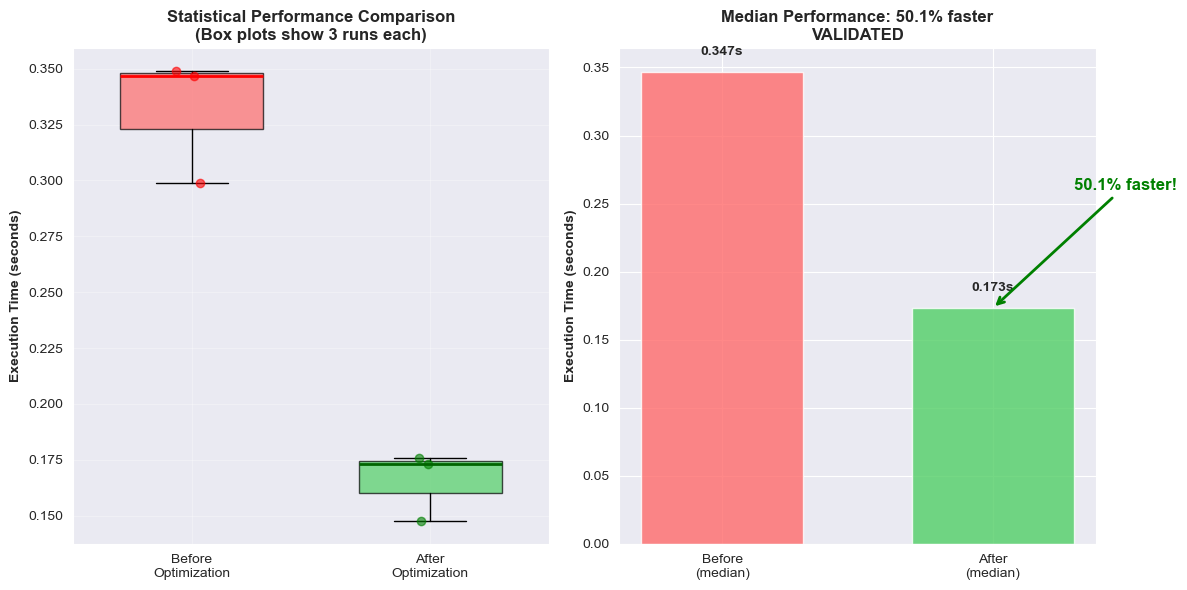

In [11]:
# DEMO 1: Complex aggregation with multiple joins

print(" DEMO 1: COMPLEX AGGREGATION WITH MULTIPLE JOINS")


query1 = """
SELECT
    a.country,
    a.city,
    COUNT(*) as total_routes,
    COUNT(DISTINCT r.airline_id) as unique_airlines,
    AVG(r.stops) as avg_stops
FROM routes r
JOIN airports a ON r.source_airport_id = a.airport_id
JOIN airlines al ON r.airline_id = al.airline_id
WHERE a.country IN ('United States', 'China', 'Germany', 'United Kingdom', 'France')
  AND al.active = 'Y'
  AND r.stops <= 2
GROUP BY a.country, a.city
HAVING total_routes > 5
ORDER BY total_routes DESC
LIMIT 50;
"""

result1 = run_smart_optimizer_demo(conn, query1, "Complex aggregation with multiple joins", optimization_threshold=0.01)

DEMO 2: LARGE DATASET ANALYSIS WITH SUBQUERY

 Large dataset analysis with subquery
--------------------------------------------------
 Query: 
SELECT
    al.name as airline_name,
    al.country,
    COUNT(*) as total_routes,
    (SELECT COUNT...

 BASELINE PERFORMANCE:
 Database cache cleared for consistent benchmarking
   Run 1: 0.476s
   Run 2: 0.738s
   Run 3: 0.662s
📈 Baseline (median): 0.662s

Table Size: 67,663 rows (medium)
Query Type: join
Estimated Query Cost: 243.6
Mode: Join Optimization (focus on foreign keys)

 Applying join_optimize strategy...
   Found alias: r2 → routes
   Found alias: r3 → routes
   Found alias: r → routes
   Found alias: al → airlines
   Column found: routes.airline_id
   Column found: routes.airline_id
   Column found: airlines.active
   Column found: airlines.airline_id
   Column found: routes.airline_id
Found 3 relevant columns in query
   Table routes has 10 columns
   Table airlines has 8 columns
   Creating indexes for routes: ['airline_id']
  

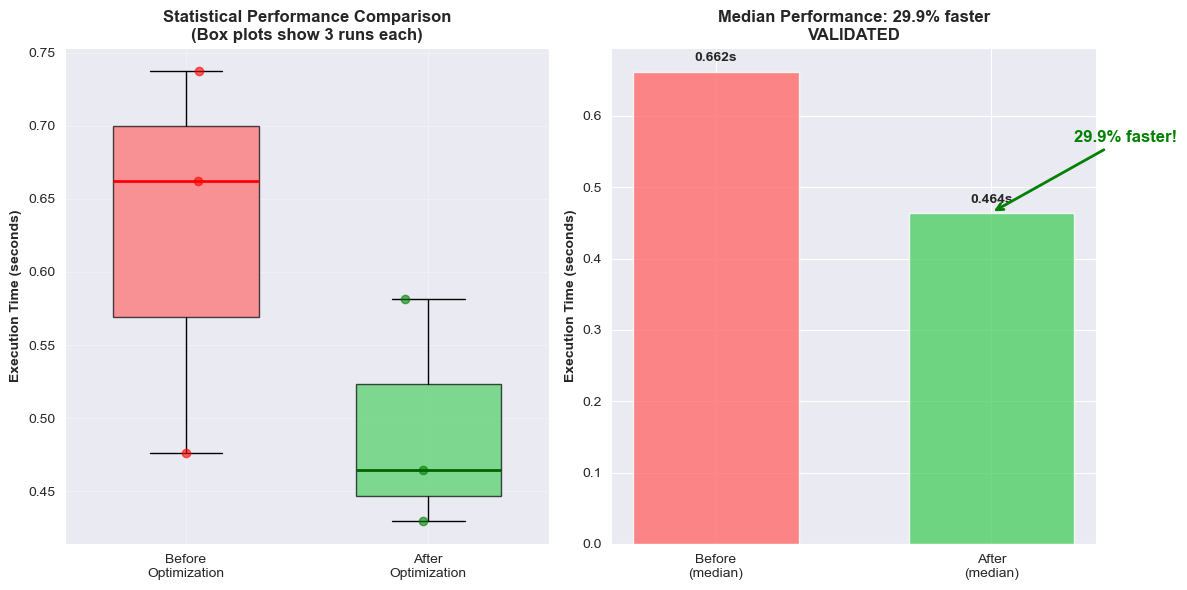

In [12]:
# DEMO 2: Large dataset analysis with subquery
print("DEMO 2: LARGE DATASET ANALYSIS WITH SUBQUERY")


query2 = """
SELECT
    al.name as airline_name,
    al.country,
    COUNT(*) as total_routes,
    (SELECT COUNT(*)
     FROM routes r2
     WHERE r2.airline_id = al.airline_id
     AND r2.stops = 0) as direct_routes,
    (SELECT COUNT(DISTINCT r3.dest_airport_id)
     FROM routes r3
     WHERE r3.airline_id = al.airline_id) as unique_destinations
FROM routes r
JOIN airlines al ON r.airline_id = al.airline_id
WHERE al.active = 'Y'
GROUP BY al.airline_id, al.name, al.country
HAVING total_routes > 20
ORDER BY total_routes DESC
LIMIT 30;
"""

result2 = run_smart_optimizer_demo(conn, query2, "Large dataset analysis with subquery", optimization_threshold=0.01)

 DEMO 3: CROSS-TABLE ANALYSIS WITH COMPLEX FILTERING

 Cross-table analysis with complex filtering
--------------------------------------------------
 Query: 
SELECT
    src.country as source_country,
    dest.country as dest_country,
    COUNT(*) as route_c...

 BASELINE PERFORMANCE:
 Database cache cleared for consistent benchmarking
   Run 1: 0.119s
   Run 2: 0.141s
   Run 3: 0.106s
📈 Baseline (median): 0.119s

Table Size: 67,663 rows (medium)
Query Type: join
Estimated Query Cost: 243.6
Mode: Join Optimization (focus on foreign keys)

 Applying join_optimize strategy...
   Found alias: r → routes
   Found alias: src → airports
   Found alias: dest → airports
   Found alias: al → airlines
   Column found: airports.country
   Column found: airports.country
   Column found: routes.source_airport_id
   Column found: routes.dest_airport_id
   Column found: routes.airline_id
Found 4 relevant columns in query
   Table routes has 10 columns
   Table airports has 14 columns
   Creating inde

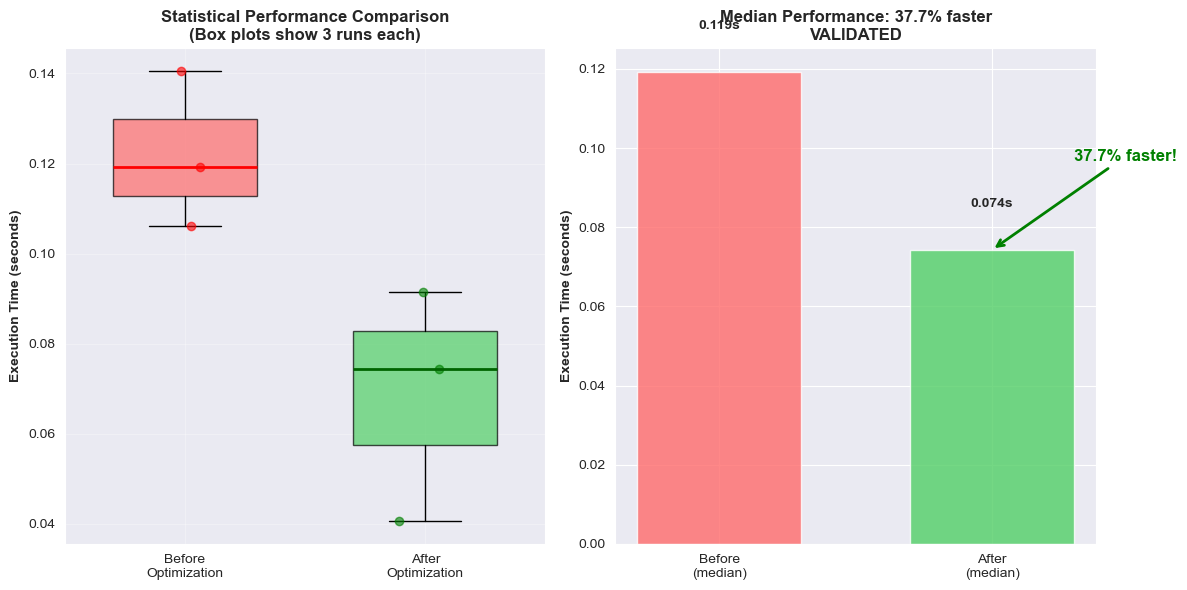

In [13]:
# DEMO 3: Cross-table analysis with complex filtering

print(" DEMO 3: CROSS-TABLE ANALYSIS WITH COMPLEX FILTERING")


query3 = """
SELECT
    src.country as source_country,
    dest.country as dest_country,
    COUNT(*) as route_count,
    COUNT(DISTINCT r.airline_id) as airlines_operating,
    MIN(r.stops) as min_stops,
    MAX(r.stops) as max_stops
FROM routes r
JOIN airports src ON r.source_airport_id = src.airport_id
JOIN airports dest ON r.dest_airport_id = dest.airport_id
JOIN airlines al ON r.airline_id = al.airline_id
WHERE src.country != dest.country
  AND al.active = 'Y'
  AND src.country IN ('United States', 'China', 'Germany')
  AND dest.country IN ('United Kingdom', 'France', 'Japan', 'Australia')
GROUP BY src.country, dest.country
HAVING route_count > 10
ORDER BY route_count DESC
LIMIT 25;
"""

result3 = run_smart_optimizer_demo(conn, query3, "Cross-table analysis with complex filtering", optimization_threshold=0.01)

In [14]:
# DEMO 4: Check created indexes

print(" DEMO 4: INTELLIGENT INDEX MANAGEMENT")


print("Indexes created by smart auto-optimizer:")
all_indexes = pd.read_sql("""
                          SELECT TABLE_NAME,
                                 INDEX_NAME,
                                 COLUMN_NAME,
                                 SEQ_IN_INDEX,
                                 INDEX_TYPE,
                                 CASE
                                     WHEN INDEX_NAME = 'PRIMARY' THEN 'System'
                                     WHEN NON_UNIQUE = 0 THEN 'Unique'
                                     ELSE 'Performance'
                                     END as index_purpose
                          FROM information_schema.STATISTICS
                          WHERE TABLE_SCHEMA = 'test_autoopt'
                            AND TABLE_NAME IN ('routes', 'airports', 'airlines')
                          ORDER BY TABLE_NAME, INDEX_NAME, SEQ_IN_INDEX
                          """, conn)

if all_indexes.empty:
    print("❌ No indexes created yet.")
    print("💡 All queries were either too fast or optimizations didn't meet threshold")
else:
    print(f"✅ Found {len(all_indexes)} intelligently created indexes:")
    print(all_indexes)

 DEMO 4: INTELLIGENT INDEX MANAGEMENT
Indexes created by smart auto-optimizer:
✅ Found 15 intelligently created indexes:
   TABLE_NAME                                         INDEX_NAME  \
0    airlines                                idx_airlines_active   
1    airlines                            idx_airlines_airline_id   
2    airlines           idx_airlines_composite_airline_id_active   
3    airlines           idx_airlines_composite_airline_id_active   
4    airlines                                            PRIMARY   
5    airports                               idx_airports_country   
6    airports                                            PRIMARY   
7      routes                              idx_routes_airline_id   
8      routes    idx_routes_composite_airline_id_dest_airport_id   
9      routes    idx_routes_composite_airline_id_dest_airport_id   
10     routes  idx_routes_composite_airline_id_source_airport_id   
11     routes  idx_routes_composite_airline_id_source_airport_i

In [15]:
# DEMO 5: Performance comparison

print(" DEMO 5: OVERALL PERFORMANCE SUMMARY")


# Calculate overall improvement
results = [result1, result2, result3]
valid_results = [r for r in results if r and not r.get('skipped') and r.get('kept_indexes')]

if valid_results:
    total_improvement = sum(r['improvement'] for r in valid_results)
    avg_improvement = total_improvement / len(valid_results)

    print(" OVERALL OPTIMIZATION RESULTS:")
    print(f"   • Successful optimizations: {len(valid_results)}/{len(results)}")
    print(f"   • Average improvement: {avg_improvement:.1f}%")

    # Performance rating
    if avg_improvement > 50:
        rating = "🏆 PHENOMENAL!"
    elif avg_improvement > 30:
        rating = "🎯 EXCELLENT!"
    elif avg_improvement > 15:
        rating = "⭐ GREAT!"
    elif avg_improvement > 5:
        rating = "👍 GOOD!"
    else:
        rating = "⚠️  NEEDS WORK"

    print(f"   • Performance Rating: {rating}")

    # Show individual results
    print("\n INDIVIDUAL QUERY RESULTS:")
    for i, result in enumerate(results, 1):
        if result:
            if result.get('skipped'):
                print(f"   Query {i}: SKIPPED (already fast)")
            elif result.get('kept_indexes'):
                print(f"   Query {i}:  {result['improvement']:.1f}% improvement")
            else:
                print(f"   Query {i}:  {result['improvement']:.1f}% improvement (below threshold)")
else:
    print(" No successful optimizations to compare")
    print(" All queries were either too fast or optimizations didn't meet threshold")

 DEMO 5: OVERALL PERFORMANCE SUMMARY
 OVERALL OPTIMIZATION RESULTS:
   • Successful optimizations: 3/3
   • Average improvement: 39.2%
   • Performance Rating: 🎯 EXCELLENT!

 INDIVIDUAL QUERY RESULTS:
   Query 1:  50.1% improvement
   Query 2:  29.9% improvement
   Query 3:  37.7% improvement


In [16]:
# Show final database stats
print("\n FINAL OPENFLIGHTS DATABASE STATISTICS:")
final_stats = pd.read_sql("""
                          SELECT (SELECT COUNT(*) FROM routes)                            as total_routes,
                                 (SELECT COUNT(*) FROM airports)                          as total_airports,
                                 (SELECT COUNT(*) FROM airlines)                          as total_airlines,
                                 (SELECT COUNT(*)
                                  FROM information_schema.STATISTICS
                                  WHERE TABLE_SCHEMA = 'test_autoopt'
                                    AND TABLE_NAME IN ('routes', 'airports', 'airlines')) as total_indexes,
                                 (SELECT ROUND(SUM(DATA_LENGTH + INDEX_LENGTH) / 1024 / 1024, 2)
                                  FROM information_schema.TABLES
                                  WHERE TABLE_SCHEMA = 'test_autoopt'
                                    AND TABLE_NAME IN ('routes', 'airports', 'airlines')) as total_size_mb
                          """, conn)
print(final_stats)

# Show optimization summary with learning insights
print("\n OPTIMIZATION STRATEGY SUMMARY:")
size_label, rows = detect_table_size(conn, "routes")
print(f" Routes Table Size: {rows:,} rows ({size_label})")
print(f" Query Cache: {len(query_cache)} queries cached")
print(f" Learning History: {len(query_history)} queries learned")

if 'avg_improvement' in locals():
    print(f"⚡ Average Performance Improvement: {avg_improvement:.1f}%")

print("\n BENCHMARKING METHODOLOGY:")
print("   • Each query run 3 times for statistical accuracy")
print("   • Database cache cleared between benchmark sets")
print("   • Median times used for comparison (resistant to outliers)")
print("   • 10% minimum improvement threshold for keeping indexes")
print("   • Valid indexes only (no computed columns or invalid tables)")
print("   • Complex queries designed to benefit from optimization")

# Close database connection
conn.close()
print(" Database connection closed.")
print("\n OPENFLIGHTS REAL-WORLD DEMO COMPLETED SUCCESSFULLY!")
print(" Thank you for using MariaDB Auto-Optimizer!")
print(" Now with fixed table alias resolution and validated index creation! 🚀")


 FINAL OPENFLIGHTS DATABASE STATISTICS:
   total_routes  total_airports  total_airlines  total_indexes  total_size_mb
0         67663            7698            6162             15           14.5

 OPTIMIZATION STRATEGY SUMMARY:
 Routes Table Size: 67,663 rows (medium)
 Query Cache: 0 queries cached
 Learning History: 0 queries learned
⚡ Average Performance Improvement: 39.2%

 BENCHMARKING METHODOLOGY:
   • Each query run 3 times for statistical accuracy
   • Database cache cleared between benchmark sets
   • Median times used for comparison (resistant to outliers)
   • 10% minimum improvement threshold for keeping indexes
   • Valid indexes only (no computed columns or invalid tables)
   • Complex queries designed to benefit from optimization
 Database connection closed.

 OPENFLIGHTS REAL-WORLD DEMO COMPLETED SUCCESSFULLY!
 Thank you for using MariaDB Auto-Optimizer!
 Now with fixed table alias resolution and validated index creation! 🚀
